# Spam classification

# 1. Get the data

In [4]:
DOWNLOAD_ROOT = 'https://spamassassin.apache.org/old/publiccorpus/'
SPAM_NAMES = ['20030228_spam.tar.bz2', '20030228_spam_2.tar.bz2', '20050311_spam_2.tar.bz2', '20021010_spam.tar.bz2']
HAM_NAMES = ['20021010_easy_ham.tar.bz2', '20021010_hard_ham.tar.bz2', '20030228_easy_ham.tar.bz2', '20030228_easy_ham.tar.bz2']
DATA_PATH = os.path.join('datasets', 'spam')

In [3]:
import os
import tarfile
import urllib

def fetch_spam_data():
    os.makedirs(DATA_PATH, exist_ok=True)
    for spam_file in SPAM_NAMES:
        spam_path = os.path.join(DATA_PATH, spam_file)
        spam_url = os.path.join(DOWNLOAD_ROOT, spam_file)
        urllib.request.urlretrieve(spam_url, spam_path)
        tgz = tarfile.open(spam_path)
        tgz.extractall(path=os.path.join(DATA_PATH, 'spam'))
        tgz.close()
    for ham_file in HAM_NAMES:
        ham_path = os.path.join(DATA_PATH, ham_file)
        ham_url = os.path.join(DOWNLOAD_ROOT, ham_file)
        urllib.request.urlretrieve(ham_url, ham_path)
        tgz = tarfile.open(ham_path)
        tgz.extractall(path=os.path.join(DATA_PATH, 'ham'))
        tgz.close()

In [6]:
fetch_spam_data()

# 2. Creating a pandas dataframe

In [37]:
import pandas as pd
import numpy as np
import glob

def label_data(path, label):
    data = []
    for filename in glob.iglob(os.path.join(path, '**/**'), recursive=True):
        if not os.path.isdir(filename):
            # some strange file sometimes occuring
            if not filename[-4:] == 'cmds':
                data.append([filename, label])
    return data

In [39]:
spamdata = label_data(os.path.join(DATA_PATH, 'spam'), label=1)
hamdata = label_data(os.path.join(DATA_PATH, 'ham'), label=0)

In [40]:
dataset = pd.DataFrame(data=[*spamdata, *hamdata], columns=['Filepath', 'Cat'])

In [41]:
dataset.head()

Filepath  Cat
0  datasets\spam\spam\spam\0000.7b1b73cf36cf9dbc3...    1
1  datasets\spam\spam\spam\00001.7848dde101aa9850...    1
2  datasets\spam\spam\spam\00002.d94f1b97e48ed3b5...    1
3  datasets\spam\spam\spam\00003.2ee33bc6eacdb11f...    1
4  datasets\spam\spam\spam\00004.eac8de8d759b7e74...    1

<br> Let's save the file as csv to restore it in the future. <br><br>

In [42]:
dataset.to_csv(os.path.join(DATA_PATH, 'dataset.csv'), index=False)

# 3. Create train/test split

In [5]:
import pandas as pd
import os

dataset = pd.read_csv(os.path.join(DATA_PATH, 'dataset.csv'))
dataset.head()

Filepath  Cat
0  datasets\spam\spam\spam\0000.7b1b73cf36cf9dbc3...    1
1  datasets\spam\spam\spam\00001.7848dde101aa9850...    1
2  datasets\spam\spam\spam\00002.d94f1b97e48ed3b5...    1
3  datasets\spam\spam\spam\00003.2ee33bc6eacdb11f...    1
4  datasets\spam\spam\spam\00004.eac8de8d759b7e74...    1

In [6]:
from sklearn.model_selection import train_test_split

y = dataset["Cat"].copy()
X = dataset.drop("Cat", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X_train

Filepath
424    datasets\spam\spam\spam\00386.6074f269f0bd1aec...
554    datasets\spam\spam\spam\0054.839a9c0a07f137185...
2992   datasets\spam\spam\spam\0094.3ba780eac7dce1c2b...
1954   datasets\spam\spam\spam_2\00957.ffe295aaf7f975...
13884  datasets\spam\ham\easy_ham\1288.9235f568fa35fd...
...                                                  ...
5191   datasets\spam\ham\easy_ham\00360.5e45677c7b7a6...
13418  datasets\spam\ham\easy_ham\0822.3ebf2e0f82aa01...
5390   datasets\spam\ham\easy_ham\00541.cbdcefd1a6109...
860    datasets\spam\spam\spam\0360.5f5fc66c831d84570...
7270   datasets\spam\ham\easy_ham\02250.f947b89c1c14a...

[12318 rows x 1 columns]

In [8]:
y_train

424      1
554      1
2992     1
1954     1
13884    0
        ..
5191     0
13418    0
5390     0
860      1
7270     0
Name: Cat, Length: 12318, dtype: int64

# 4. Data exploration
## 4.1 Spam/Ham ratio

In [9]:
exploration_set = pd.concat([X_train, y_train], axis=1)

In [10]:
exploration_set.head()

Filepath  Cat
424    datasets\spam\spam\spam\00386.6074f269f0bd1aec...    1
554    datasets\spam\spam\spam\0054.839a9c0a07f137185...    1
2992   datasets\spam\spam\spam\0094.3ba780eac7dce1c2b...    1
1954   datasets\spam\spam\spam_2\00957.ffe295aaf7f975...    1
13884  datasets\spam\ham\easy_ham\1288.9235f568fa35fd...    0

In [11]:
exploration_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12318 entries, 424 to 7270
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filepath  12318 non-null  object
 1   Cat       12318 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 288.7+ KB


In [12]:
exploration_set.describe()

Cat
count  12318.000000
mean       0.309547
std        0.462326
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000

<AxesSubplot:>

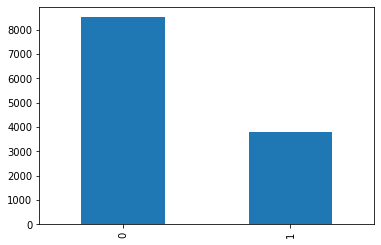

In [13]:
exploration_set['Cat'].value_counts().plot(kind='bar')

In [15]:
import numpy as np

counts = exploration_set['Cat'].value_counts()
percentage = counts[1] / np.sum(counts)
print(f'Spam percentage {percentage}')

Spam percentage 0.30954700438382854


<br> From the [README file](https://spamassassin.apache.org/old/publiccorpus/readme.html) we can get that the percentage of spam is 31%, so our split got that right <br><br>

## 4.2 Email parsing
<br> Let's parse one email and see what we got <br><br>

In [50]:
import email

file_object = open(exploration_set.iloc[0]['Filepath'], 'rb')
msg = email.parser.BytesParser().parse(file_object)

In [51]:
print(f"Message is \n: {msg.as_string()} \n\n This message is {'spam' if exploration_set.iloc[0]['Cat'] == 1 else 'ham'}")

Message is 
: Return-Path: <sunday68@bluemail.dk>
Delivered-To: zzzz@localhost.spamassassin.taint.org
Received: from localhost (jalapeno [127.0.0.1])
	by zzzzason.org (Postfix) with ESMTP id 8FD3716F03
	for <zzzz@localhost>; Fri, 20 Sep 2002 11:41:21 +0100 (IST)
Received: from jalapeno [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Fri, 20 Sep 2002 11:41:21 +0100 (IST)
Received: from webnote.net (mail.webnote.net [193.120.211.219]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g8K3lHC19280 for
    <zzzz@jmason.org>; Fri, 20 Sep 2002 04:47:17 +0100
Received: from bluemail.dk (host230-95.pool21756.interbusiness.it
    [217.56.95.230]) by webnote.net (8.9.3/8.9.3) with SMTP id EAA04124;
    Fri, 20 Sep 2002 04:47:45 +0100
Date: Fri, 20 Sep 2002 04:47:45 +0100
From: sunday68@bluemail.dk
Reply-To: <sunday68@bluemail.dk>
Message-Id: <004e01e10eca$6576b5b2$0dd22cc2@qtnqof>
To: paulifree@hotmail.com
Subject: FORTUNE 500 WORK AT HOME REPS NEE

In [52]:
file_object = open(exploration_set.iloc[5]['Filepath'], 'r')
msg_two = email.message_from_file(file_object)
print(f"Message is \n: {msg_two.as_string()} \n\n This message is {'spam' if exploration_set.iloc[5]['Cat'] == 1 else 'ham'}")

Message is 
: Return-Path: <rssfeeds@spamassassin.taint.org>
Delivered-To: yyyy@localhost.spamassassin.taint.org
Received: from localhost (jalapeno [127.0.0.1])
	by jmason.org (Postfix) with ESMTP id AAC2316F20
	for <jm@localhost>; Thu,  3 Oct 2002 12:23:19 +0100 (IST)
Received: from jalapeno [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Thu, 03 Oct 2002 12:23:19 +0100 (IST)
Received: from dogma.slashnull.org (localhost [127.0.0.1]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g9381uK20003 for
    <jm@jmason.org>; Thu, 3 Oct 2002 09:01:56 +0100
Message-Id: <200210030801.g9381uK20003@dogma.slashnull.org>
To: yyyy@spamassassin.taint.org
From: gamasutra <rssfeeds@spamassassin.taint.org>
Subject: Shader Integration: Merging Shading Technologies on the Nintendo
    Gamecube
Date: Thu, 03 Oct 2002 08:01:56 -0000
Content-Type: text/plain; encoding=utf-8

URL: http://www.newsisfree.com/click/-4,8494551,159/
Date: 2002-10-03T05:50:07+01:00

R

<br><br> Let's test some other functions of the Message object <br> Print the subject of an email: <br><br>

In [53]:
print(f"Subject of email is: {msg.get('subject')}")

Subject of email is: FORTUNE 500 WORK AT HOME REPS NEEDED!


In [58]:
print(f"Body of email is: \n{msg.get_payload()}")

Body of email is: 
Immediate Help Needed.  We are a fortune 500 company that is 
growing at a tremendous rate of over 1000% per year. We simply cannot 
keep up. We are looking for motivated individuals who are looking to 
earn a substantial income working from home. 

This is a real opportunity to make an excellent income from home. No 
experience is required.  We will provide you with any training you may need. 

We are looking for energetic and self motivated people.  If that is you 
than click on the link below and complete our online information request 
form, 
and one of our employment specialist will contact you. 

http://ter.netblah.com:27000

So if you are looking to be employed at home, with a career that will 
provide you vast opportunities and a substantial income, please fill 
out our online information request form here now: 

http://ter.netblah.com:27000


To be removed from our list simply click on the link below now: 

http://ter.netblah.com:27000

1631Pl5





## 4.3 Transforming into a Vector

In [61]:
import nltk
nltk.download('punkt')

tokens = nltk.word_tokenize(msg.get('subject'))
print(tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


['FORTUNE', '500', 'WORK', 'AT', 'HOME', 'REPS', 'NEEDED', '!']
